# Module 5 Final Project Submission

Please fill out:
* Student name: Fernando Aguilar Islas
* Student pace: Part-time
* Scheduled project review date/time: TBD
* Instructor name: Brandon Lewis
* Blog post URL: TBD


## 1. Introduction
For this project I will use the Online Shoppers Purchasing Intention Dataset which contains information about website visitors and their behaviour on the site. This dataset tracks the user as revenue generating or not. The aim of this project is to build a model that can accurately calssify a user as revenue generating or not given its exhibited when visiting the website.


## 2 Framework
For this data set I will first perform exploration and data analysis, since all variables are categorical, I will mostly look for missing values and the content of each feature. Next, I will fit single model classifiers such as KNN, support vectors and decision trees. I will also tune the hyperparameters to obtain the best results. Further, I will look into ensembles such as Bagging, Random Forests,and XGBoost, to see if they outperform the single model classifier. Since ideally the classifier could be used as an app for people pacticing outdoor activities, I will prefer single model classifiers that require less memory capacity and not very computationally expensive. Let's start by importing the necessary libraries for the project.

### 2.1 Import Required Libraries

In [22]:
# EDA tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Single model classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

#Ensemble classifications models
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost as xgb

#Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report,roc_curve, auc,
f1_score, recall_score, precision_score)

# Hyperparameter tunning and pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## 2.2 Helper Functions

In [2]:
def best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=10):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1

## 3. EDA and Pre-processing


In [3]:
#Load the file into a pandas data frame.
data = pd.read_csv("online_shoppers_intention.csv")
#Get structural information of the data set.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

In [4]:
#Visualize first 5 rows of data of the first 9 columns.
data.head().iloc[:,:9]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0


In [5]:
#Visualize first 5 rows of data of the remaining columns.
data.head().iloc[:,9:]

,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


From this first inspection at the data contained in the dataset, some of the numerical features are actually categorical such as OperatingSystems, Browser, and Region, to name a few. Before doing feature engineering, i will first look for missing or dummy values in the data and outliers.

In [6]:
#Look for missing values.
data.isna().any()

Administrative             False
Administrative_Duration    False
Informational              False
Informational_Duration     False
ProductRelated             False
ProductRelated_Duration    False
BounceRates                False
ExitRates                  False
PageValues                 False
SpecialDay                 False
Month                      False
OperatingSystems           False
Browser                    False
Region                     False
TrafficType                False
VisitorType                False
Weekend                    False
Revenue                    False
dtype: bool

The dataset does not contain any missing values. Let's have a deeper look at the numerical variables in the dataset. I will start by describing the numerical features. Next, I will view at the histograms and lastly I will inspect boxplots.

In [33]:
data.describe().iloc[:,:8]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000


In [34]:
data.describe().iloc[:,8:]

,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


The numerical features in the data set are made up off continuous, discrete and categorical variables. I will look at the unique number of values in each of the varibles with discrete values, to divide them into numerous or categorical variables.

In [59]:
#Get number of unique values for each discrete variable in the dataset.
for col in data.describe().columns:
    if data[col].dtype == int:
        print(f'{col}:', data[col].nunique())

Administrative: 27
Informational: 17
ProductRelated: 311
OperatingSystems: 8
Browser: 13
Region: 9
TrafficType: 20


With this information I will use the Administrative, Informational, and ProductRelated as Discrete variables since each of . the values is the amount of pages per category the user viewed during the session. I will use OperatingSystems, Browser, region, and TrafficType as categorical variables since there is not a numerical relationship amongts the different values, but they are label encoded to differentiate amongst operating system, and browser used by the user, his geographic region, and how the user got the site. I will gather more insight by looking at the histograms.

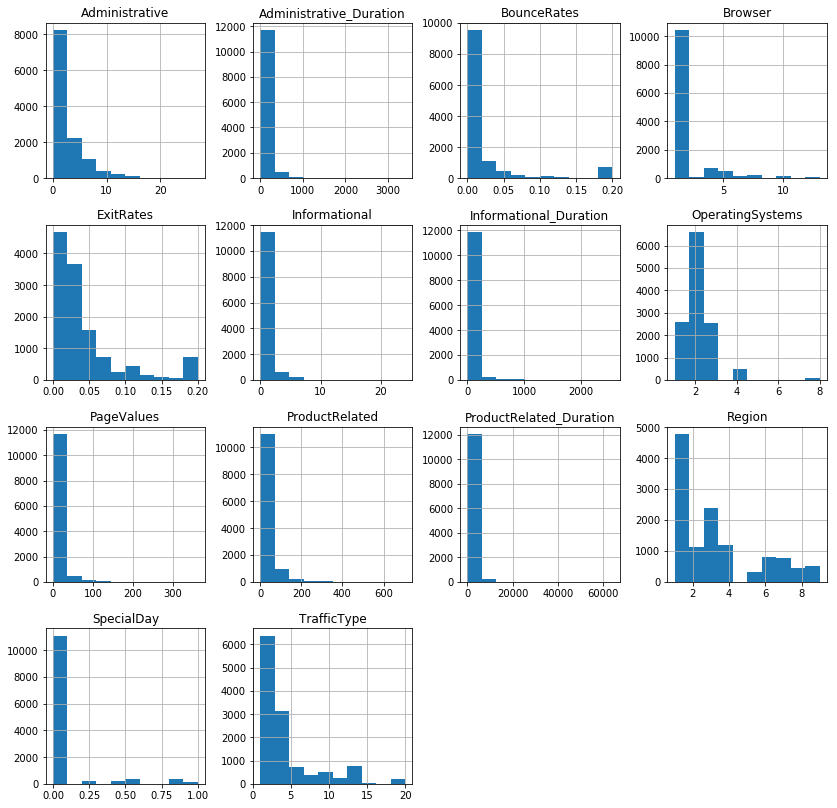

In [60]:
data[data.describe().columns].hist(figsize=(14,14));

In [55]:
print('Non-numerical features: ',(list(set(data.columns) - set(data.describe().columns))))

Non-numerical features:  ['Month', 'Weekend', 'Revenue', 'VisitorType']


False    10422
True      1908
Name: Revenue, dtype: int64


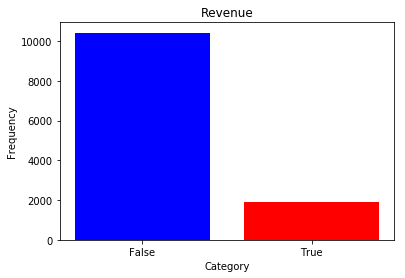

In [7]:
#Visualize distribution of the target variable in the dataset
print(data['Revenue'].value_counts())
plt.bar(['False','True'], data['Revenue'].value_counts(), color=['b','r'])
plt.title('Revenue')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.show();

In [24]:
#Split the dataset into target and features dataframes.
#Change boolean data type to string for one-hot coding the target variable.
target = data['Revenue'].astype(str).map({'False':1,'True':0})
features = data.drop('Revenue', axis=1)

In [25]:
#Drop veil-type from the features.
#features.drop('veil-type', axis=1, inplace=True)

#One-hot-code the features
ohc_feats = pd.get_dummies(features, drop_first=True)
print('New number of columns: ', ohc_feats.columns.shape[0])
ohc_feats.columns

New number of columns:  26


Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend',
       'Month_Dec', 'Month_Feb', 'Month_Jul', 'Month_June', 'Month_Mar',
       'Month_May', 'Month_Nov', 'Month_Oct', 'Month_Sep', 'VisitorType_Other',
       'VisitorType_Returning_Visitor'],
      dtype='object')

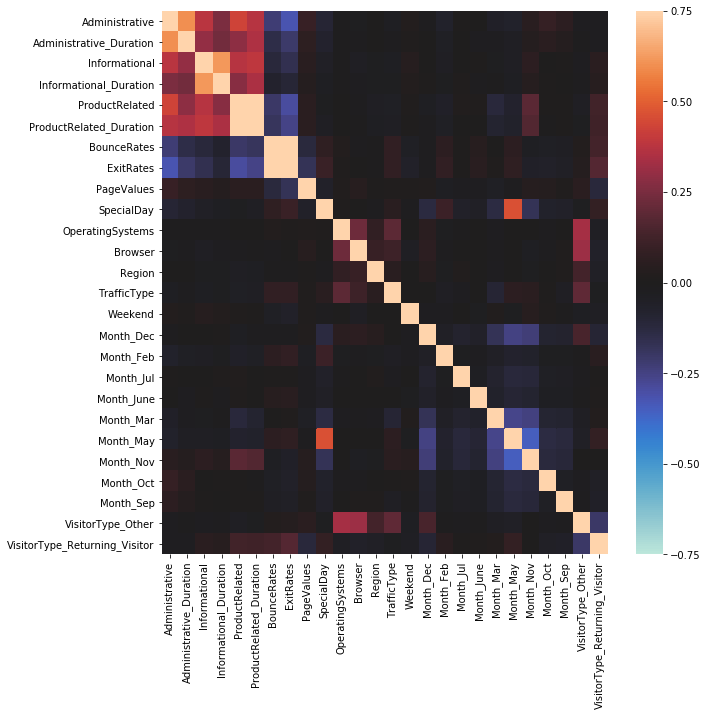

In [26]:
plt.figure(figsize=(10,10))
sns.heatmap(ohc_feats.corr(),vmin=-0.75,vmax=0.75,center=0);

In [27]:
pca = PCA(n_components=0.9)
pca_feats = pca.fit_transform(ohc_feats)
print(np.sum(pca.explained_variance_ratio_))
pca.n_components_

0.9877351180787426


1

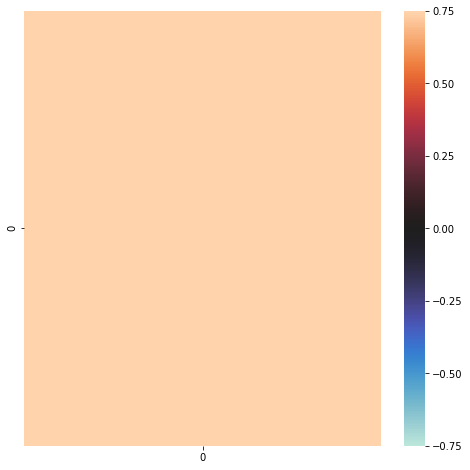

In [28]:
plt.figure(figsize=(8,8))
sns.heatmap(pd.DataFrame(pca_feats).corr(),vmin=-0.75,vmax=0.75,center=0);

In [29]:
X_train, X_test, y_train, y_test = train_test_split(ohc_feats,target,test_size=0.3,random_state=617)

In [30]:
clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
test_preds = clf.predict(X_test)
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 0.8881789137380192
Recall Score: 0.9711019371228962
Accuracy Score: 0.871316572046499
F1 Score: 0.9277912621359223


In [15]:
find_best_k(X_train, y_train, X_test, y_test)

NameError: name 'find_best_k' is not defined

## 7. Bibliography and References
* Dataset: Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). https://link.springer.com/article/10.1007%2Fs00521-018-3523-0